# Study energy resolution for low-threshold hits (contained and not)


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes
import bes.display       as nplay
import bes.chits         as chits

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu Nov 26 20:46:53 2020


### Load data

In [5]:
runs   = [8182, 8183, 8184]
fnames = [bes.get_esmeralda_filename(run)  for run in runs]
dfts   = [bes.get_esmeralda_dfcomposite(fname) for fname in fnames]
dft    = bes.df_concat(dfts, runs)

In [6]:
selections, ranges = bes.get_selections_dfcomposite(dft)

In [7]:
print(selections)

numb_of_tracks.one : numb_of_tracks [0.5, 1.5), 1742048, 0.54361
evt_out_of_map.False : evt_out_of_map [False, False], 2755197, 0.85977
energy : energy [0.0, 3.0), 3204248, 0.99990
energy.cs : energy [0.65, 0.71), 68703, 0.02144
energy.ds : energy [1.55, 1.75), 25361, 0.00791
energy.ph : energy [2.5, 3.0), 1461, 0.00046
enecor.cs : enecor [0.65, 0.71), 71613, 0.02235
enecor.ds : enecor [1.55, 1.75), 25678, 0.00801
enecor.ph : enecor [2.5, 3.0), 2334, 0.00073
z_min : z_min [50.0, 500.0), 2707418, 0.84486
z_max : z_max [50.0, 500.0), 2741249, 0.85542
r_max : r_max [0.0, 180.0), 2400680, 0.74914
dz_track.cs : dz_track [8.0, 32.0), 1185869, 0.37005
dz_track.ds : dz_track [24.0, 72.0), 229659, 0.07167
dz_track.ph : dz_track [35.0, 130.0), 114231, 0.03565
fidutial : evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0), 1112373, 0.34712
fidutial.cs : evt_out_of_map [False, False] & numb_of_tracks [0.5, 1

### Consider the contained low-threshold hits events

In [8]:
### load run-event list of contained and non-contained for ds
fname = './events_lowTh_hits_contained.h5'
for sample in ['ds', 'ph']:
    
    dfcon  = pd.read_hdf(fname, sample + '.contained')
    print('contained ', sample, len(dfcon))
    selections.set_isin(dfcon, 'lthits.' + sample + '.contained')
    dfncon = pd.read_hdf(fname, sample + '.non_contained')
    print('non contained ', sample, len(dfncon))
    selections.set_isin(dfncon, 'lthits.' + sample +'.non_contained');

    selections.logical_and(('fidutial.' + sample, 'lthits.' + sample +'.contained'),
                           'fidutial.' + sample + '.contained')
    selections.logical_and(('fidutial.' + sample, 'lthits.' + sample +'.non_contained'), 
                           'fidutial.' + sample +'.non_contained')
    
print(selections)

contained  ds 4904
non contained  ds 3228
contained  ph 361
non contained  ph 302
numb_of_tracks.one : numb_of_tracks [0.5, 1.5), 1742048, 0.54361
evt_out_of_map.False : evt_out_of_map [False, False], 2755197, 0.85977
energy : energy [0.0, 3.0), 3204248, 0.99990
energy.cs : energy [0.65, 0.71), 68703, 0.02144
energy.ds : energy [1.55, 1.75), 25361, 0.00791
energy.ph : energy [2.5, 3.0), 1461, 0.00046
enecor.cs : enecor [0.65, 0.71), 71613, 0.02235
enecor.ds : enecor [1.55, 1.75), 25678, 0.00801
enecor.ph : enecor [2.5, 3.0), 2334, 0.00073
z_min : z_min [50.0, 500.0), 2707418, 0.84486
z_max : z_max [50.0, 500.0), 2741249, 0.85542
r_max : r_max [0.0, 180.0), 2400680, 0.74914
dz_track.cs : dz_track [8.0, 32.0), 1185869, 0.37005
dz_track.ds : dz_track [24.0, 72.0), 229659, 0.07167
dz_track.ph : dz_track [35.0, 130.0), 114231, 0.03565
fidutial : evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0), 111

In [9]:
def str_energy_resolution(pars, upars, label = ''):
    label = label + ': \t' if label != '' else ''
    ss  = label + r' $\sigma$ = {0:6.4f} $\pm$ {1:6.4f}'.format(abs(pars[2]), upars[2]) + '\n'
    mu, sigma, umu, usigma = pars[1], pars[2], upars[1], upars[2]
    R  = 235 * abs(sigma)/mu
    uR = 235 * np.sqrt(usigma**2 + R**2 * umu**2)/mu
    ss += label + r' R  = {0:6.4f} $\pm$ {1:6.4f}'.format(R, uR)+ '\n'
    return ss

def plt_text(ss, x0 = 0.05, y0 = 0.7):
    props = dict(boxstyle='square', facecolor='white', alpha= 0.5)
    plt.text(x0, y0, ss, transform = plt.gca().transAxes, bbox = props, verticalalignment = 'top')

evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75)
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.non_contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0)
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [

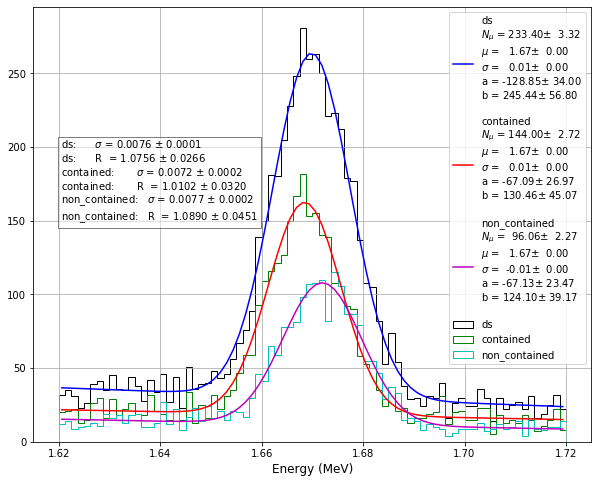

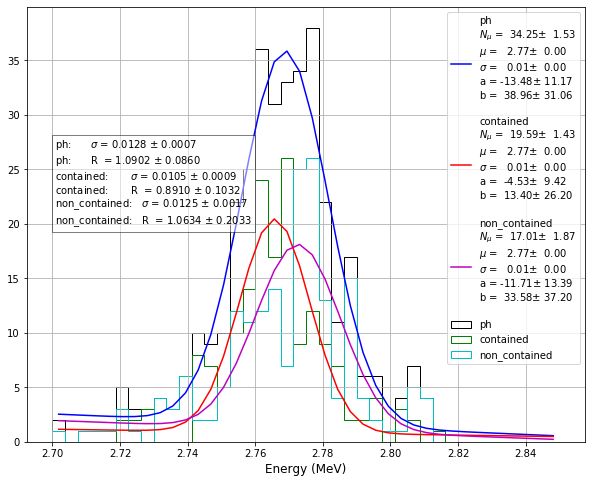

In [10]:
ene = 'enecor'

for sample in ['ds', 'ph']:

    sels = ['fidutial.' + sample , 'fidutial.' + sample + '.contained', 'fidutial.' + sample + '.non_contained']

    bins    = 80                        if sample == 'ds' else 40
    range_e = (1.62, 1.72)              if sample == 'ds' else (2.7, 2.85)
    guess   = (100, 1.66, 0.02, 0., 20) if sample == 'ds' else (40, 2.75, 0.02, 0., 10)

    pltext.canvas(1, 1, 8, 10)
    ss = ''
    for sel in sels:
        xsel  = selections[sel]
        print(xsel.info)
        label = sel.split('.')[-1]
        pars, upars = pltext.hfit(dft[xsel][ene], bins, 'gausline', guess = guess,
                                 label = label, range = range_e);
        ss += str_energy_resolution(pars, upars, label)
        plt.xlabel('Energy (MeV)', fontsize = 12)
    plt_text(ss[:-1])


In [11]:
def dfs_inspect(dfs, dfnames = None, labels = None, bins = 100, ranges = {}, ncolumns = 2):
    """ histogram the variables of a a list of dataframes
    inputs:
        dfs     : tuple(dataframe)
        dfnames : tuple(str), list of the name of the dataframes.
        labels  : tuple(str) list of variables. if None all the columns of the DF
        bins    : int (100), number of nbins
        ranges  : dict, range of the histogram, the key must be the column name
        ncolumns: int (2), number of columns of the canvas
    """
    ndfs    = len(dfs)
    dfnames = [str(i) for i in range(ndfs)] if dfnames is None else dfnames
    if (labels is None):
        labels = list(dfs[0].columns)
    #print('labels : ', labels)
    subplot = pltext.canvas(len(labels), ncolumns)
    for i, xlabel in enumerate(labels):
        subplot(i + 1)
        for j, df in enumerate(dfs):
            values = ut.remove_nan(df[xlabel].values)
            xrange = None if label not in ranges.keys() else ranges[xlabel]
            pltext.hist(values, bins, range = xrange, label = dfnames[j], density = True)
            plt.xlabel(xlabel);

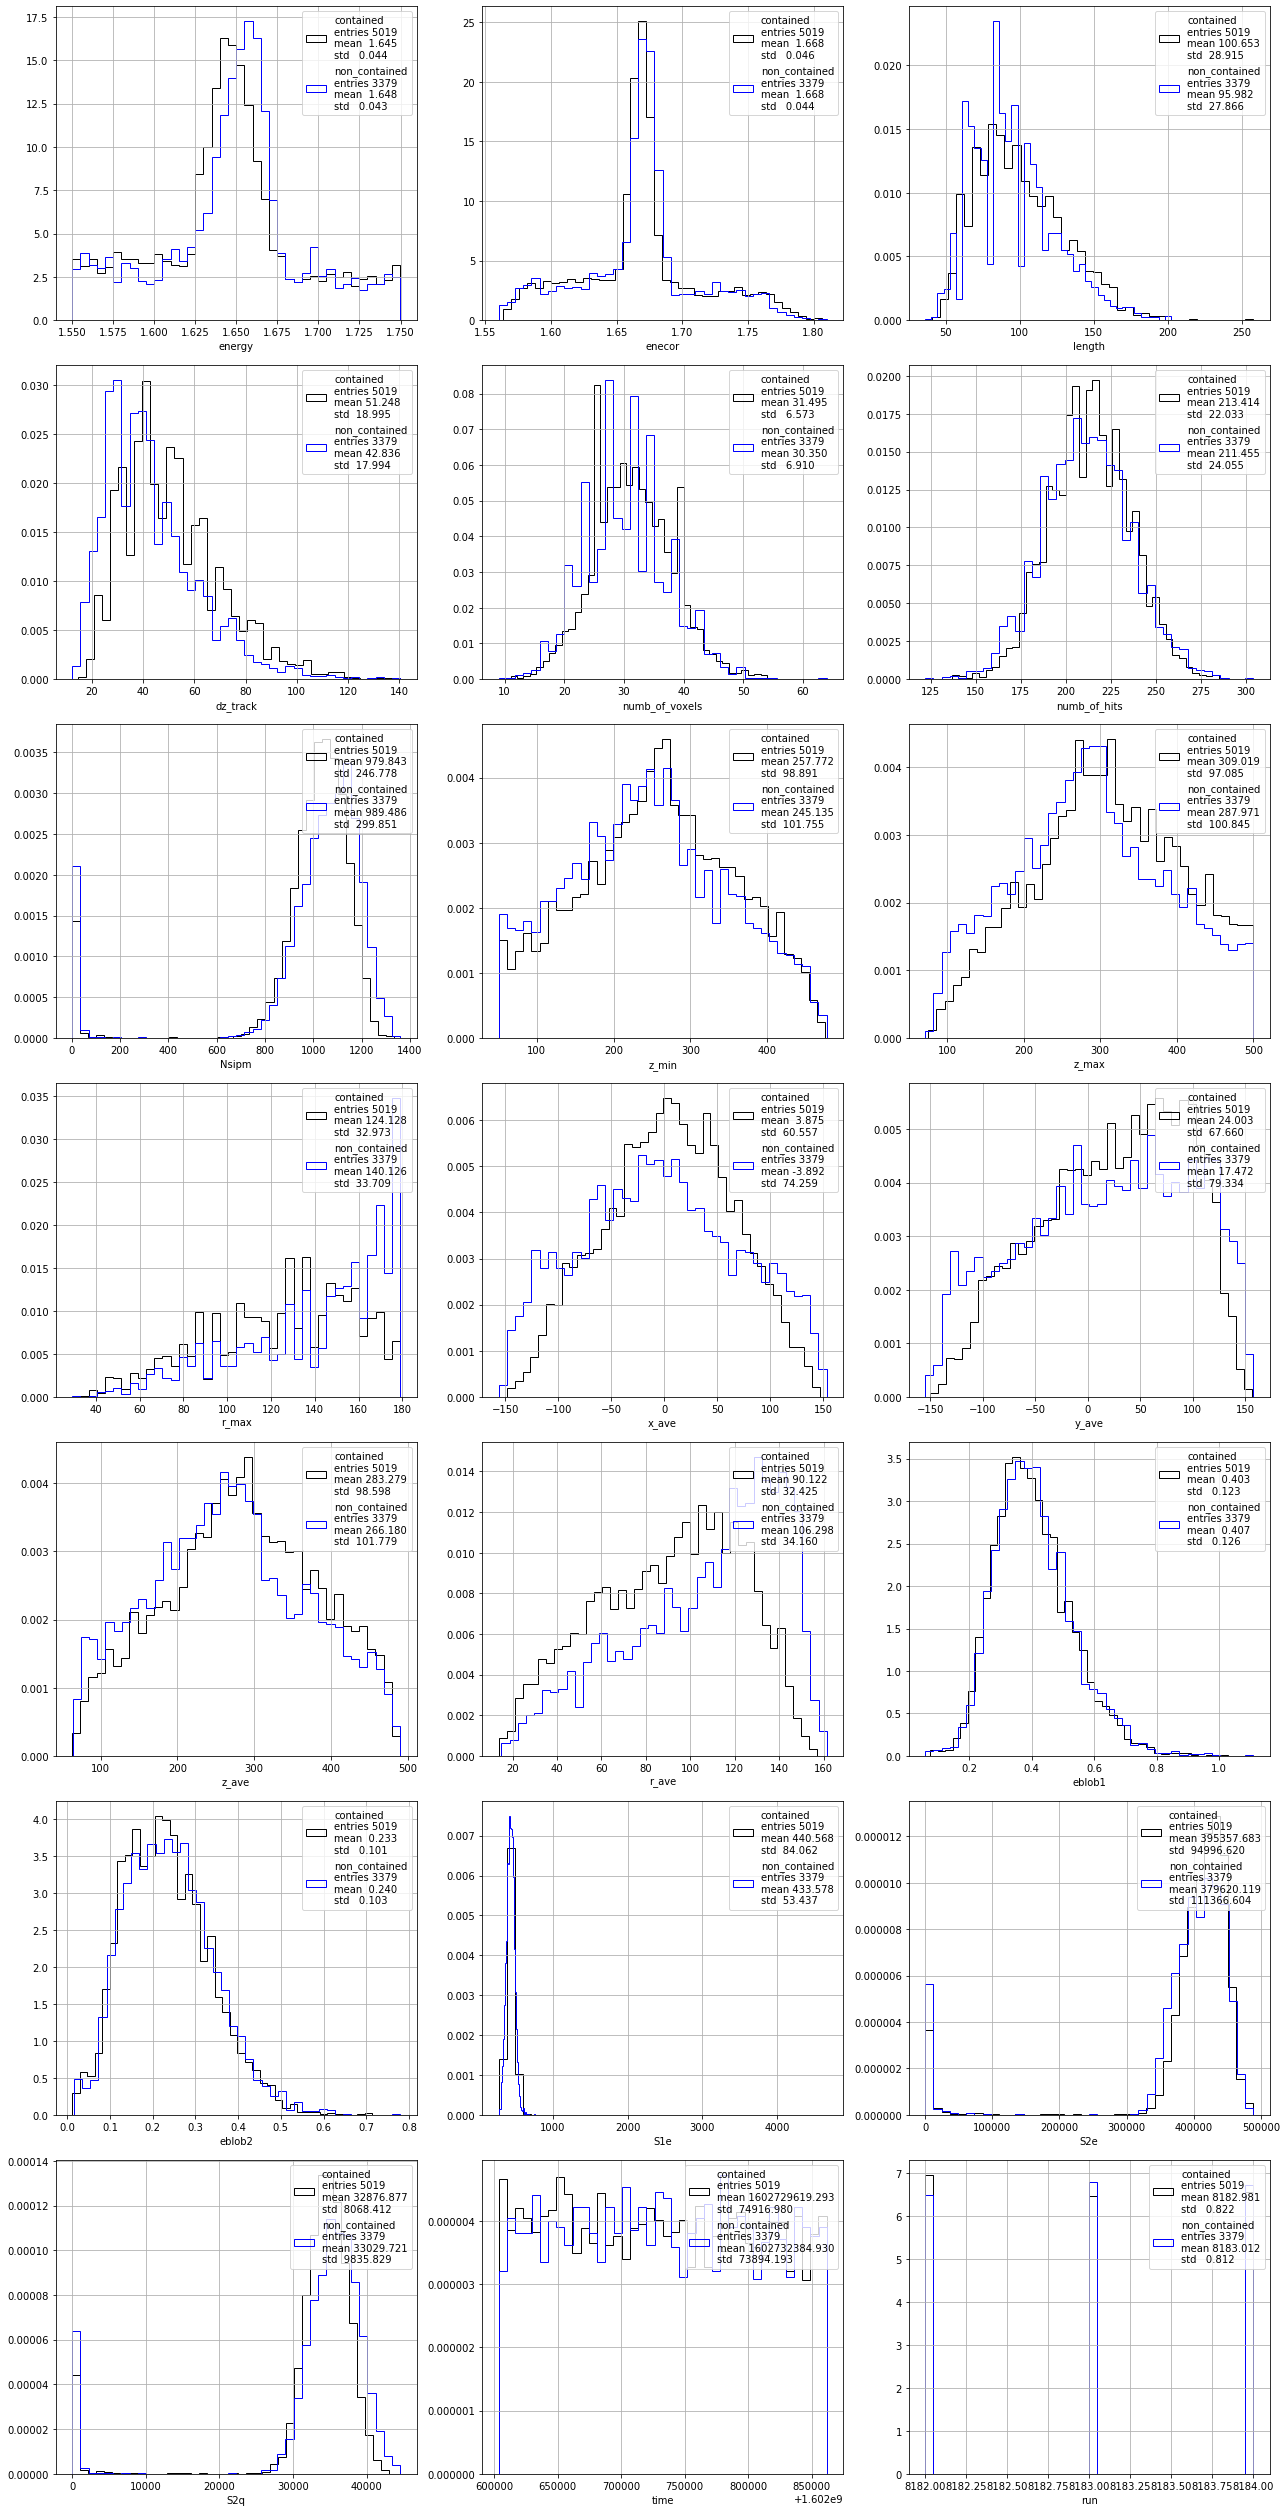

In [12]:
names   = ['fidutial.ds.contained', 'fidutial.ds.non_contained']
dfs     = [dft[selections[name]] for name in names]
dfnames = [name.split('.')[-1]  for name in names] 
labels  = ['energy', 'enecor', 
           'length', 'dz_track', 
           'numb_of_voxels', 'numb_of_hits',  'Nsipm',
           'z_min', 'z_max', 'r_max', 
           'x_ave', 'y_ave', 'z_ave', 'r_ave',
           'eblob1', 'eblob2', 
           'S1e', 'S2e', 'S2q', 
           'time', 'run']

pltext.dfs_inspect(dfs, dfnames, labels, bins = 40, ncolumns = 3)

**Conclusions:**

  * non-contained events are in general: shorter in length and dz-track, closer to the anode, in general large maximum radius. In average are more in the exterior of x, y and radius. Maybe larger charge in SiPMs and PMTs,

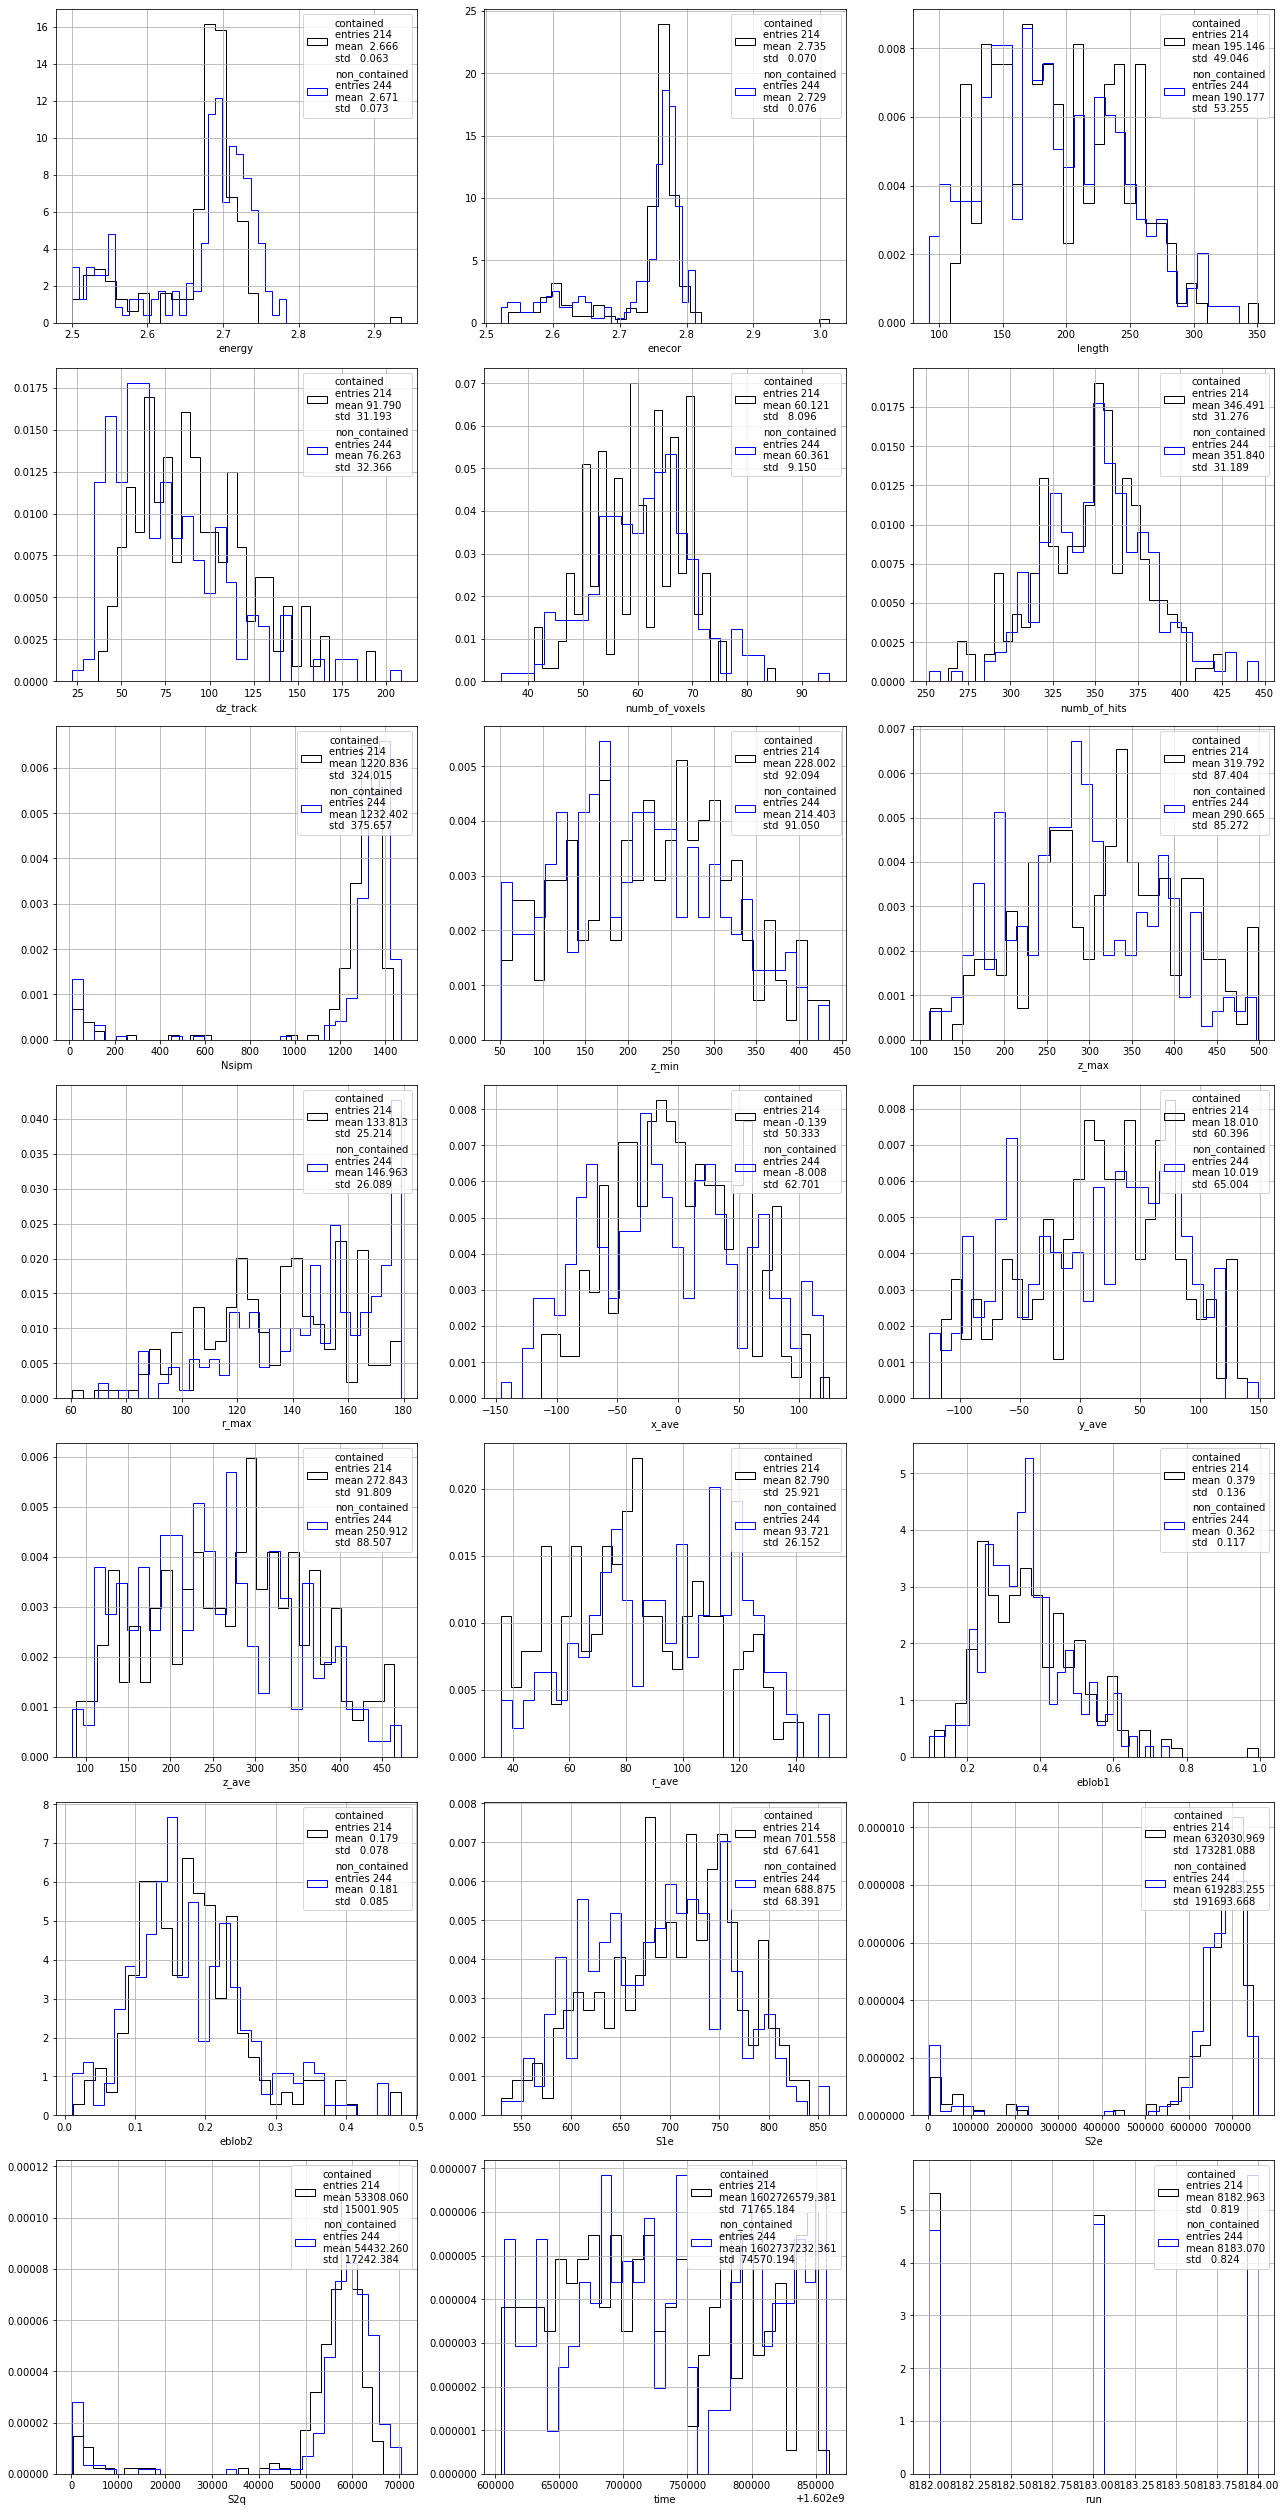

In [13]:
names   = ['fidutial.ph.contained', 'fidutial.ph.non_contained']
dfs     = [dft[selections[name]] for name in names]
dfnames = [name.split('.')[-1]  for name in names] 
labels  = ['energy', 'enecor', 
           'length', 'dz_track', 
           'numb_of_voxels', 'numb_of_hits',  'Nsipm',
           'z_min', 'z_max', 'r_max', 
           'x_ave', 'y_ave', 'z_ave', 'r_ave',
           'eblob1', 'eblob2', 
           'S1e', 'S2e', 'S2q', 
           'time', 'run']

pltext.dfs_inspect(dfs, dfnames, labels, bins = 30, ncolumns = 3)

**Conclusions: **

   * Situation is similar for PH events, non-contained tracks are shorter and close to the anode with larger charge.

## Correlations for contained/non-contained

ds fidutial.ds.contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.contained
ds fidutial.ds.non_contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.non_contained
ph fidutial.ph.contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.contained
ph fidutial.ph.non_contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.non_contained


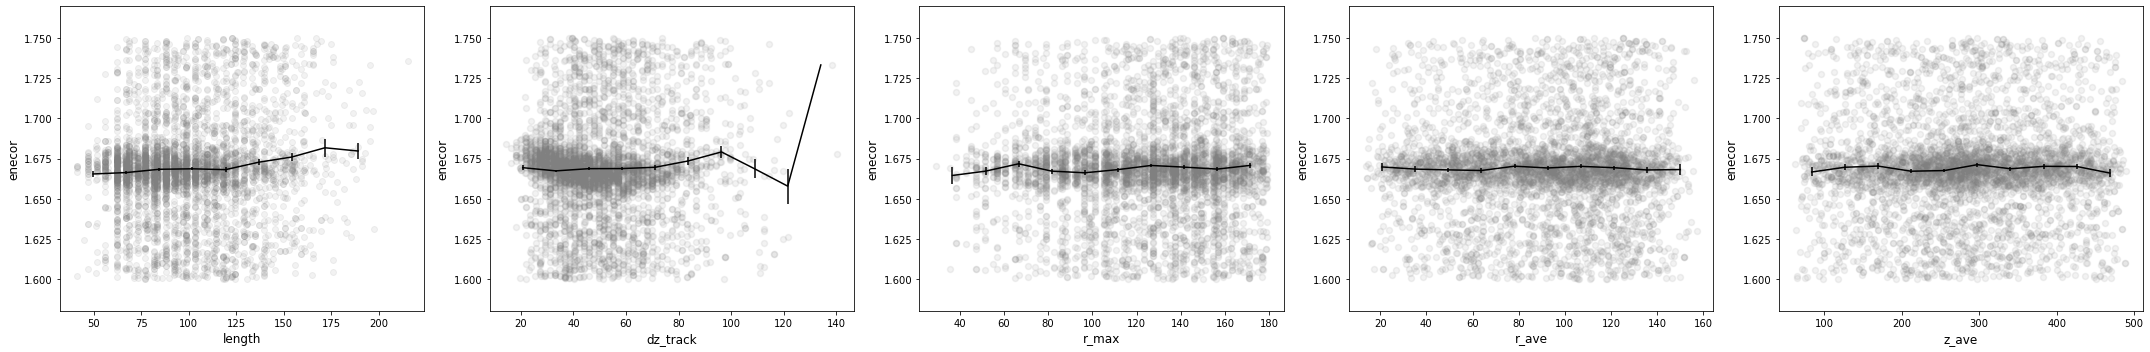

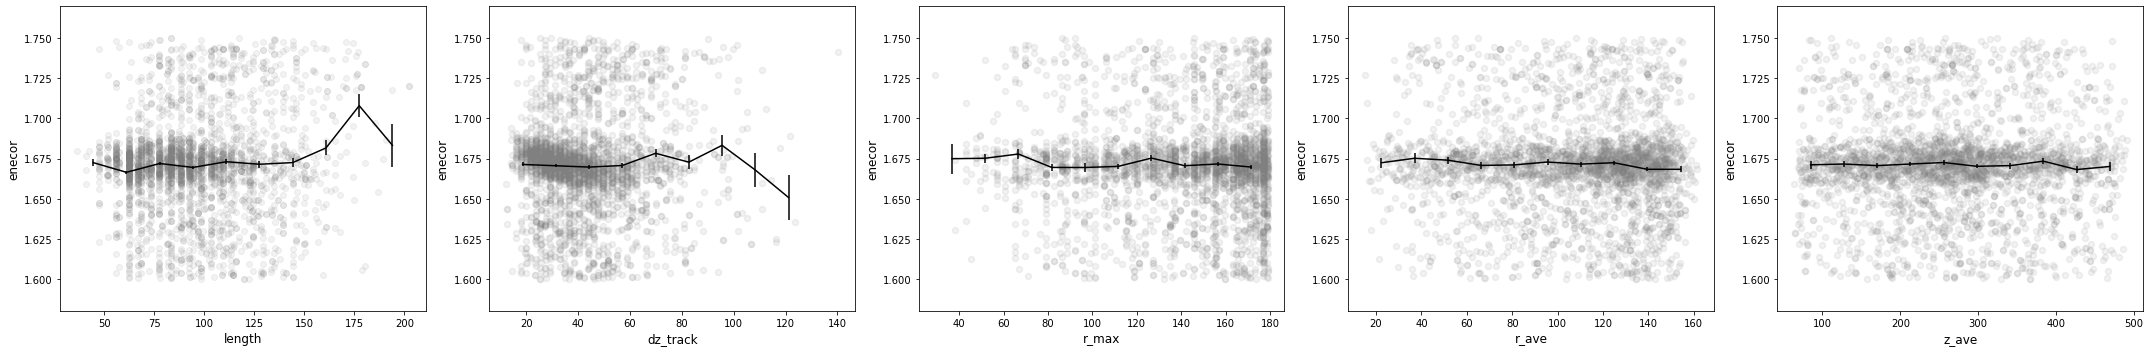

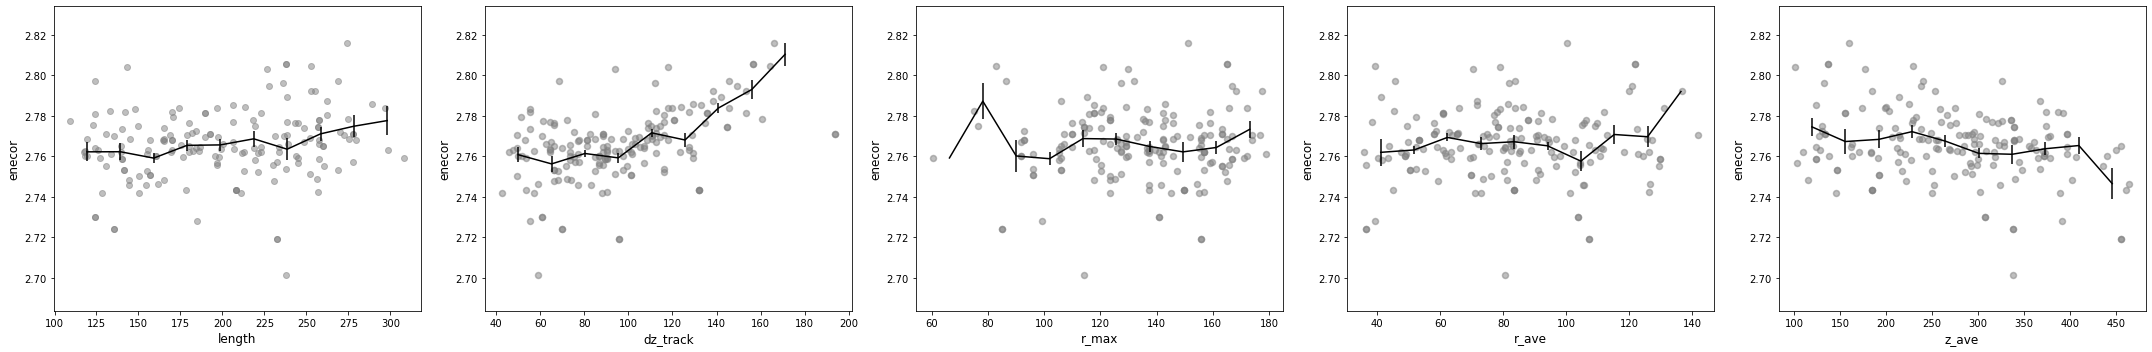

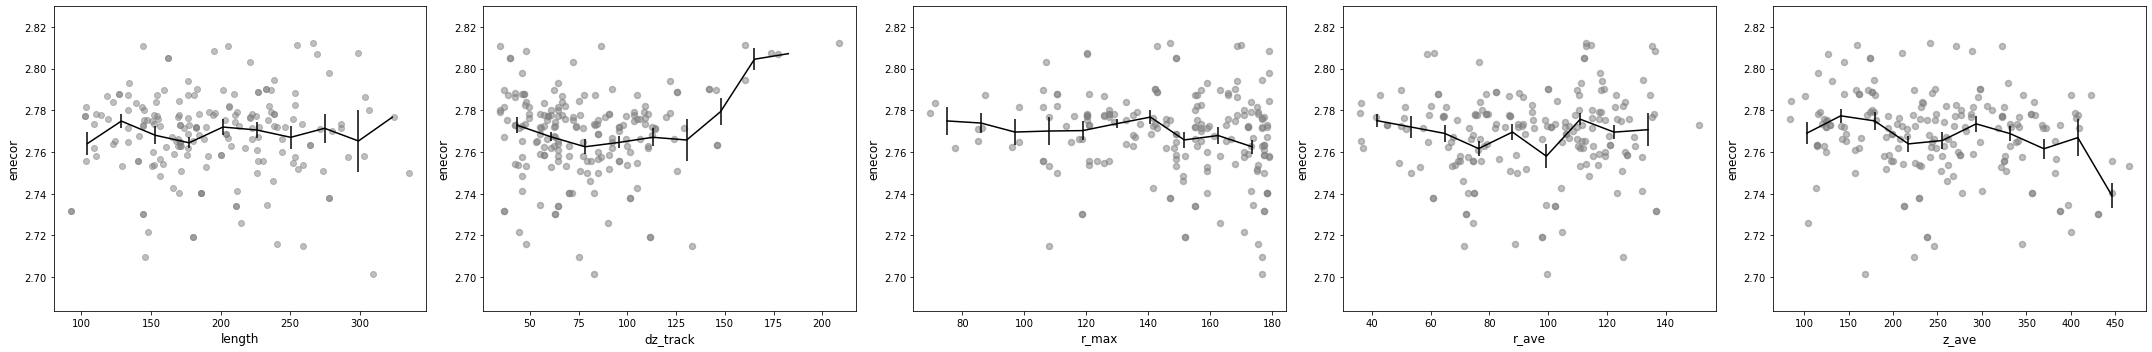

In [35]:
samples = ['ds', 'ph']
label  = 'enecor'
labels = ['length', 'dz_track', 'r_max', 'r_ave', 'z_ave']

for sample in samples:
    erange = (1.6, 1.75) if sample == 'ds' else (2.70, 2.85)
    esel   = ut.in_range(dft.enecor, erange)
    alpha  = 0.1        if sample == 'ds' else 0.5
    selnames = ['fidutial.' + sample + '.contained', 'fidutial.' + sample + '.non_contained']
    for selname in selnames:
        xsel = selections[selname]
        print(sample, selname, ' : ', xsel.info)
        pltext.df_corrprofile(dft[xsel & esel], label, labels, switch = True, alpha = alpha)

**Conclusions:**

  * There is still some bias in the global dz-correction, it looks that the correction has two slopes.
  
  * This is clear for the ph, starting at 100 mm, there is a clear bias.
  
  * For the non-contained events resolutions degrades it maximum radious is 140 or average 110 mm aprox.
  
  * Other dependencies are null.